In [4]:
pip install rasterio geopandas matplotlib pandas numpy seaborn pysal

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import seaborn as sns
from pysal.explore import esda
from pysal.lib import weights

# File paths
sdg_faowocat = "/content/drive/MyDrive/data/EOSLDN/GlobalData/EU/clipped_SDG_2015_2019_FAOWOCAT_EU.tif"
lpd_faowocat = "/content/drive/MyDrive/data/EOSLDN/GlobalData/EU/clipped_LPD_2005_2019_FAOWOCAT_EU.tif"

sdg_jrc = "/content/drive/MyDrive/data/EOSLDN/GlobalData/EU/clipped_SDG_2015_2019_JRC_EU.tif"
lpd_jrc = "/content/drive/MyDrive/data/EOSLDN/GlobalData/EU/clipped_LPD_2005_2019_JRC_EU.tif"

sdg_te = "/content/drive/MyDrive/data/EOSLDN/GlobalData/EU/clipped_SDG_2015_2019_TE_EU.tif"
lpd_te = "/content/drive/MyDrive/data/EOSLDN/GlobalData/EU/clipped_LPD_2005_2019_TE_EU.tif"

# Function to load and align rasters
def load_rasters(sdg_path, lpd_path):
    with rasterio.open(sdg_path) as src_sdg:
        sdg = src_sdg.read(1)
        meta = src_sdg.meta

    with rasterio.open(lpd_path) as src_lpd:
        lpd = src_lpd.read(1)
        # Ensure LPD matches SDG dimensions
        if lpd.shape != sdg.shape:
            raise ValueError("Raster dimensions don't match")

    return sdg, lpd, meta

# Load all pairs
sdg_faw, lpd_faw, meta = load_rasters(sdg_faowocat, lpd_faowocat)
sdg_jrc, lpd_jrc, _ = load_rasters(sdg_jrc, lpd_jrc)
sdg_te, lpd_te, _ = load_rasters(sdg_te, lpd_te)

/usr/local/lib/python3.12/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


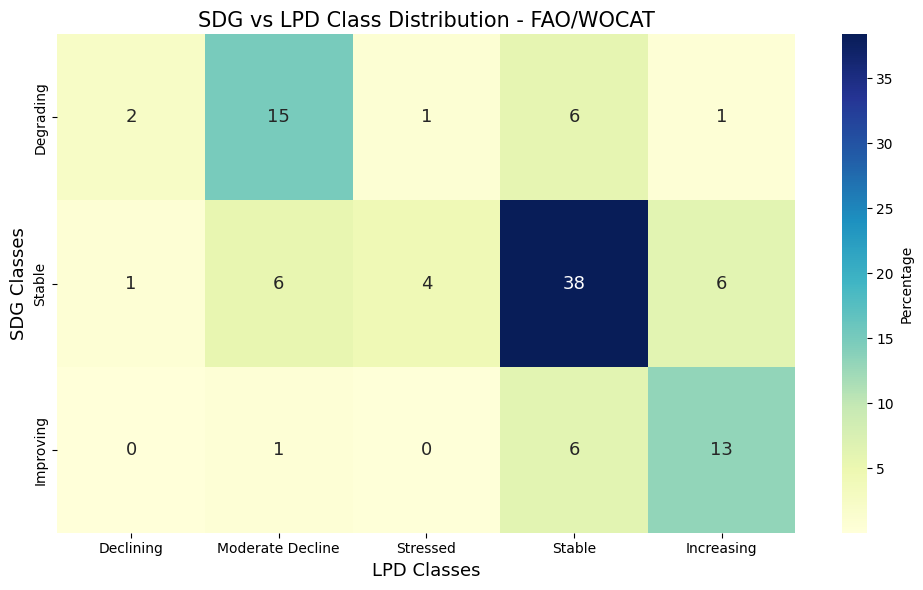

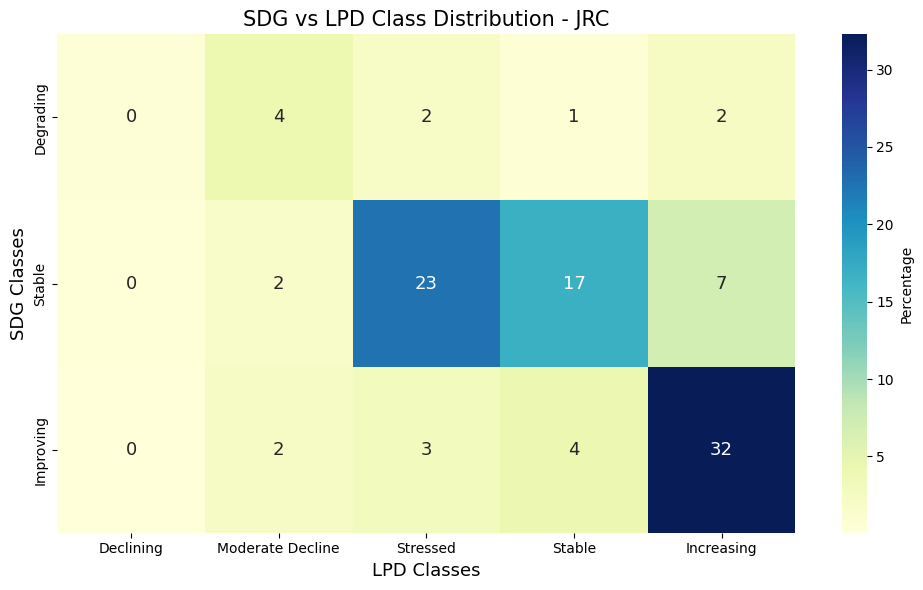

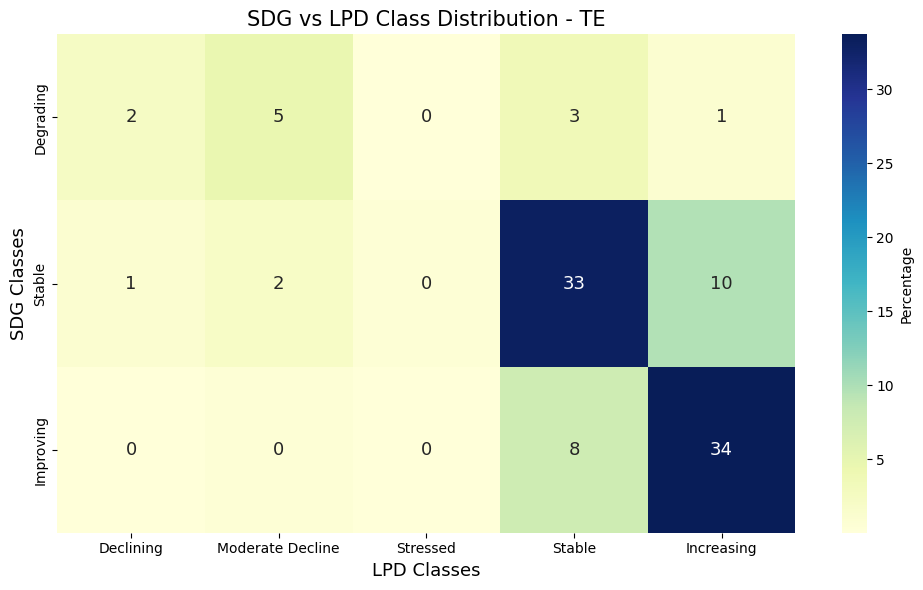

In [32]:
def create_correlation_matrix(sdg_data, lpd_data, title):
    # Create cross-tabulation
    sdg_flat = sdg_data.flatten()
    lpd_flat = lpd_data.flatten()

    # Filter valid data (SDG: 1-4, LPD: 1-5)
    valid_mask = (sdg_flat >= 1) & (sdg_flat <= 3) & (lpd_flat >= 1) & (lpd_flat <= 5)
    sdg_valid = sdg_flat[valid_mask]
    lpd_valid = lpd_flat[valid_mask]

    # Check if we have any valid data
    if len(sdg_valid) == 0 or len(lpd_valid) == 0:
        print(f"No valid data points for {title}")
        return None

    # Map numeric codes to meaningful labels
    sdg_labels = {
        1: 'Degrading',
        2: 'Stable',
        3: 'Improving',
        #4: 'Water'
    }

    lpd_labels = {
        1: 'Declining',
        2: 'Moderate Decline',
        3: 'Stressed',
        4: 'Stable',
        5: 'Increasing'
    }

    # Convert to categorical with labels
    sdg_cat = pd.Categorical(
        [sdg_labels[x] for x in sdg_valid],
        categories=['Degrading', 'Stable', 'Improving']
    )

    lpd_cat = pd.Categorical(
        [lpd_labels[x] for x in lpd_valid],
        categories=['Declining', 'Moderate Decline', 'Stressed', 'Stable', 'Increasing']
    )

    # Create contingency table
    ct = pd.crosstab(
        sdg_cat,
        lpd_cat,
        rownames=['SDG Classes'],
        colnames=['LPD Classes'],
        normalize='all'
    )

    # Plot heatmap if we have data
    if not ct.empty:
        # Scale the contingency table by 100 to get integer percentages
        ct_scaled = ct * 100

        plt.figure(figsize=(10, 6))
        sns.heatmap(ct_scaled,  # Use scaled data
                    annot=True,
                    fmt=".0f",  # Format annotations as integers (e.g., 2, 15)
                    cmap="YlGnBu",
                    cbar_kws={'label': 'Percentage', 'format': '%.0f'}, # Integer format for color bar
                    annot_kws={'fontsize': 13})
        plt.xlabel("LPD Classes", fontsize=13)
        plt.ylabel("SDG Classes", fontsize=13)
        plt.title(f"SDG vs LPD Class Distribution - {title}", fontsize=15)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid data to plot for {title}")

    return ct

# Generate correlation matrices with error handling
try:
    ct_faw = create_correlation_matrix(sdg_faw, lpd_faw, "FAO/WOCAT")
except Exception as e:
    print(f"Error processing FAO/WOCAT: {str(e)}")
    ct_faw = None

try:
    ct_jrc = create_correlation_matrix(sdg_jrc, lpd_jrc, "JRC")
except Exception as e:
    print(f"Error processing JRC: {str(e)}")
    ct_jrc = None

try:
    ct_te = create_correlation_matrix(sdg_te, lpd_te, "TE")
except Exception as e:
    print(f"Error processing TE: {str(e)}")
    ct_te = None

In [14]:
def calculate_class_correlations(ct_matrix):
    # Calculate correlation coefficients between class distributions
    corr_coeff = np.corrcoef(ct_matrix.values)
    return corr_coeff

# Calculate for all datasets
corr_faw = calculate_class_correlations(ct_faw)
corr_jrc = calculate_class_correlations(ct_jrc)
corr_te = calculate_class_correlations(ct_te)

print("FAO/WOCAT Class Correlation Matrix:\n", corr_faw)
print("\nJRC Class Correlation Matrix:\n", corr_jrc)
print("\nTE Class Correlation Matrix:\n", corr_te)

FAO/WOCAT Class Correlation Matrix:
 [[ 1.          0.11265869 -0.35057411]
 [ 0.11265869  1.          0.29050553]
 [-0.35057411  0.29050553  1.        ]]

JRC Class Correlation Matrix:
 [[ 1.         -0.22425544  0.18216266]
 [-0.22425544  1.         -0.07962841]
 [ 0.18216266 -0.07962841  1.        ]]

TE Class Correlation Matrix:
 [[ 1.          0.31615114 -0.30255942]
 [ 0.31615114  1.          0.24179883]
 [-0.30255942  0.24179883  1.        ]]
